### Setup

In [32]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

In [33]:
data = pd.read_csv("/Users/kiem/Developer/data/creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [34]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
138824,82865.0,1.2,-0.7,0.0,-0.9,-0.6,-0.0,-0.4,0.0,2.0,...,0.1,0.3,-0.4,-1.0,0.9,-0.4,0.1,0.0,89.0,0
214646,139760.0,-1.2,1.0,1.6,1.0,0.2,0.5,-0.0,0.8,-0.3,...,-0.5,-1.3,-0.2,-0.5,0.4,-0.8,0.2,0.0,1.0,0
12179,21245.0,-1.6,0.9,1.1,-1.5,0.3,-1.2,1.3,-0.4,1.5,...,-0.3,-0.2,-0.2,0.4,0.4,0.8,0.0,0.3,75.0,0
122973,76758.0,-3.0,3.0,-0.7,-1.1,-1.2,-0.0,-2.6,-4.0,-1.0,...,-2.5,0.6,0.5,-0.1,-0.2,0.8,0.0,0.2,9.0,0
257643,158272.0,0.2,1.1,-0.5,-0.6,1.1,-0.7,1.0,-0.1,-0.1,...,-0.3,-0.8,0.1,0.4,-0.4,0.1,0.2,0.1,2.7,0


In [35]:
data.ndim

2

### Data Wrangling

In [36]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,...,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,94813.9,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,88.3,0.0
std,47488.1,2.0,1.7,1.5,1.4,1.4,1.3,1.2,1.2,1.1,...,0.7,0.7,0.6,0.6,0.5,0.5,0.4,0.3,250.1,0.0
min,0.0,-56.4,-72.7,-48.3,-5.7,-113.7,-26.2,-43.6,-73.2,-13.4,...,-34.8,-10.9,-44.8,-2.8,-10.3,-2.6,-22.6,-15.4,0.0,0.0
25%,54201.5,-0.9,-0.6,-0.9,-0.8,-0.7,-0.8,-0.6,-0.2,-0.6,...,-0.2,-0.5,-0.2,-0.4,-0.3,-0.3,-0.1,-0.1,5.6,0.0
50%,84692.0,0.0,0.1,0.2,-0.0,-0.1,-0.3,0.0,0.0,-0.1,...,-0.0,0.0,-0.0,0.0,0.0,-0.1,0.0,0.0,22.0,0.0
75%,139320.5,1.3,0.8,1.0,0.7,0.6,0.4,0.6,0.3,0.6,...,0.2,0.5,0.1,0.4,0.4,0.2,0.1,0.1,77.2,0.0
max,172792.0,2.5,22.1,9.4,16.9,34.8,73.3,120.6,20.0,15.6,...,27.2,10.5,22.5,4.6,7.5,3.5,31.6,33.8,25691.2,1.0


In [37]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

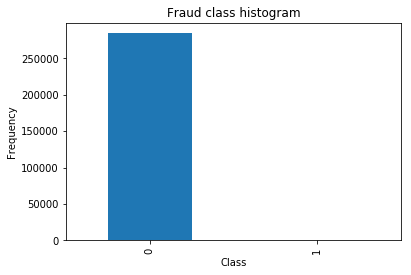

In [38]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [39]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

In [40]:
#cols_to_norm = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
#       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
#       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [41]:
#data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max()-x.min()))

In [42]:
#data.head()

### Define Features and Configure Feature Columns

In [43]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [44]:
# Define the input feature: Only use the 'Amount' and 'V1' to 'V28' features
#my_features = data[['Amount'] + ['V%d' % number for number in range(1, 29)]]

# Configure a numeric feature columns
#feature_columns = tf.feature_column.numeric_column(my_features.columns)

In [45]:
X = data.iloc[:, 1:30].values
y = data.iloc[:, 30].values

In [46]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(X_train.shape)

(227845, 29)


### Build a Model

In [47]:
# Initialising the ANN
classifier = Sequential()

In [48]:
# Adding the Input layer and the first hidden layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform', input_dim = 29))

# Adding the second hidden layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform'))

# Adding the output layer
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the training set
classifier.fit(X_train, y_train, batch_size = 100, epochs = 100)


Epoch 1/100
227845/227845 [==============================] - 3s 14us/step - loss: 0.0447 - acc: 0.9979
Epoch 2/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0091 - acc: 0.9983
Epoch 3/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.0053 - acc: 0.9983
Epoch 4/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.0044 - acc: 0.9993
Epoch 5/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0042 - acc: 0.9994
Epoch 6/100
227845/227845 [==============================] - 3s 15us/step - loss: 0.0039 - acc: 0.9994: 0s - loss: 0.0036 -
Epoch 7/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0037 - acc: 0.9994
Epoch 8/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0038 - acc: 0.9994
Epoch 9/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.0035 - acc: 0.9994
Epoch 10/100
227845/227845 [========================

227845/227845 [==============================] - 3s 12us/step - loss: 0.0027 - acc: 0.9994: 0s - loss: 0.002
Epoch 77/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0027 - acc: 0.9994: 0s - loss: 0.0027 - acc: 
Epoch 78/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0025 - acc: 0.9995: 
Epoch 79/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.0026 - acc: 0.9995
Epoch 80/100
227845/227845 [==============================] - 3s 15us/step - loss: 0.0025 - acc: 0.9994
Epoch 81/100
227845/227845 [==============================] - 4s 16us/step - loss: 0.0027 - acc: 0.9995
Epoch 82/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0026 - acc: 0.9994
Epoch 83/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.0025 - acc: 0.9995: 0s - loss: 0.0025 - acc: 0.999
Epoch 84/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.0026 - acc: 0.999

### Make prediction and evaluating the model

In [49]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Convert to T or F boolean value
y_pred = (y_pred > 0.5)

In [50]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[56835,    17],
       [   20,    90]])

### XGBoost

In [51]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Make prediction and evaluating the model

In [52]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

/Users/kiem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[56845,     7],
       [   21,    89]])

In [30]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv=10)
print(accuracies.mean())
print(accuracies.std())

/Users/kiem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kiem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kiem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kiem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

0.00012750052821458287